In [1]:
from init import *

In [2]:
filter_mask = filter(stock_list,date_list)

def data_clean(factor):
    # 剔除ST、涨停、停牌、新股、动态券池
    factor = factor.mask(filter_mask).dropna(how = 'all')
    # 离群值处理
    factor = factor.apply(lambda x :filter_extreme_MAD(x,3), axis=1)
    # 标准化
    factor = standardize(factor)
    # 行业市值中性化
    factor = neutralization(factor)
    # 标准化
    factor = standardize(factor)
    
    return factor

new_stock_filter load
st_filter load
suspended_filter load
limit_up_down_filter load


In [70]:
#### 基本面因子

# 应收账款周转率
rat_mrq_ttm = Factor("operating_revenue_mrq_0") / Factor("net_accts_receivable_ttm_0")

# 现金流动负债比率
ccr_mrq = Factor('cash_flow_from_operating_activities_mrq_0')/Factor('current_liabilities_mrq_0')

# 股息率
dp_ttm = Factor('dividend_yield_ttm')



factor_names = {
    'liq_turn_avg':liq_turn_avg,
    'liq_vstd':liq_vstd,
    'liq_zamount':liq_zamount,
    'corr_price_turn':corr_price_turn,
    'mmt_normal_M':mmt_normal_M,
    'mmt_overmight_M':mmt_overmight_M,
    'rat_mrq_ttm':rat_mrq_ttm,
    'ccr_mrq':ccr_mrq,
    'dp_ttm':dp_ttm,
    'apr_mrq':apr_mrq,
    'ocf_yoy_mrq':ocf_yoy_mrq,
    'gpmd_ttm':gpmd_ttm,
    'ffoa_ttm':ffoa_ttm,
    'ep_mrq':ep_mrq,
    'np_parent_mrq':np_parent_mrq,
    'dpr':dpr,
    'fatdy_mrq':fatdy_mrq
}

In [63]:
factor_dict = {}
ic_df = pd.DataFrame()

In [2]:
factor_dict = pd.read_pickle('factor_dict.pkl')
ic_df = pd.read_pickle('ic_df.pkl')

In [71]:
done_name = list(factor_dict.keys())
for k,v in factor_names.items():
    if k in done_name:
        pass
    else:
        print(f'{k} loading... ')
        df = execute_factor(v,stock_list,start_date,end_date)
        df = data_clean(df)
        factor_dict[k] = df
        ic_temp,*_ = Quick_Factor_Return_N_IC(df,20,k)
        ic_df = pd.concat([ic_df,ic_temp.to_frame(k)],axis = 1)

fatdy_mrq loading... 


100%|██████████| 1801/1801 [00:40<00:00, 44.05it/s]


{'name': 'fatdy_mrq', 'IC mean': 0.0153, 'IC std': 0.0414, 'IR': 0.3699, 'IR_ly': 0.2167, 'IC>0': 0.6569, 'ABS_IC>2%': 0.6474, 't_stat': 15.6121}


In [207]:
factor_dict['apr_mrq'].std(axis = 1)

datetime
2016-02-01    1.0
2016-02-02    1.0
2016-02-03    1.0
2016-02-04    1.0
2016-02-05    1.0
             ... 
2023-06-26    1.0
2023-06-27    1.0
2023-06-28    1.0
2023-06-29    1.0
2023-06-30    1.0
Length: 1801, dtype: float64

In [176]:
pickle.dump(factor_dict,open('factor_dict.pkl','wb'))
ic_df.to_pickle('ic_df.pkl')

In [128]:
# 累计ic图
def cumic(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 累计ic图 -> plot
    """
    ic_df[name].cumsum().plot()

# 热力图    
def hot_corr(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 热力图 -> plt
    """
    ax = plt.subplots(figsize=(len(name), len(name)))#调整画布大小
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.3, square=True, annot= True,cmap = 'Blues')   #annot=True 表示显示系数
    plt.title('Factors_IC_CORRELATION')
    # 设置刻度字体大小
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

def ic_analysis(ic_df):
    return pd.concat([ic_df.mean().to_frame('IC'),(ic_df.mean()/ic_df.std()).to_frame('IR')],axis = 1)

In [177]:
compare = ic_analysis(ic_df)
compare

,IC,IR
liq_turn_avg,0.095730,0.910500
liq_zamount,0.058887,1.017844
corr_price_turn,0.064953,0.965118
mmt_normal_M,0.054143,0.540213
rat_mrq_ttm,0.029704,0.427697
ccr_mrq,0.019297,0.426976
dp_ttm,0.035603,0.596828
apr_mrq,0.007828,0.239547
ocf_yoy_mrq,0.006723,0.183438
liq_vstd,0.065896,0.764712


In [156]:
ic_df[compare[compare.IR < 0 ].index] = -ic_df[compare[compare.IR < 0 ].index]
factor_dict[compare[compare.IR < 0 ].index] = -factor_dict[compare[compare.IR < 0 ].index]

<AxesSubplot: xlabel='datetime'>

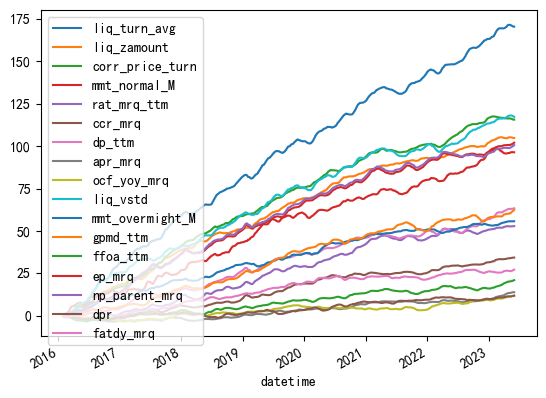

In [157]:
ic_df.cumsum().plot()

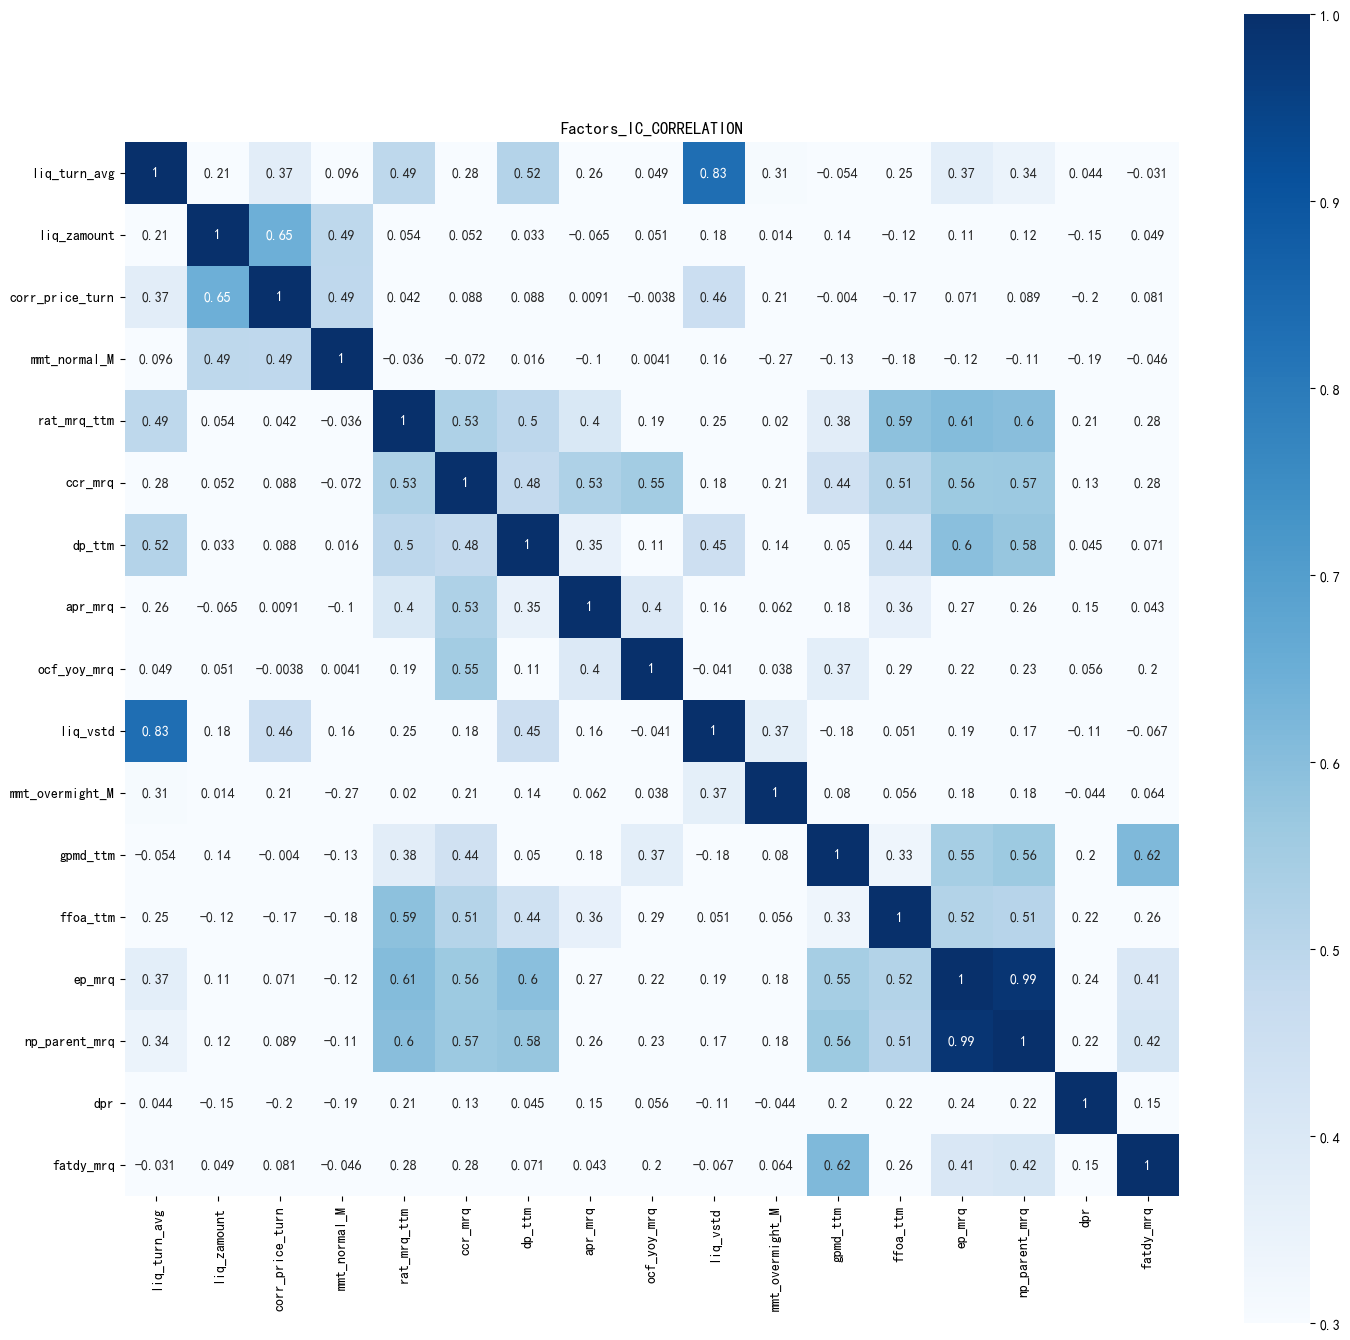

In [153]:
hot_corr(ic_df.columns,ic_df)

In [80]:
""" 因子ic序列相关性聚类 """
from sklearn.cluster import KMeans
from sklearn import metrics

def corr_analysis(factor_pair,low,high = 1):
    corr_group = {}
    ## 高相关性分析
    factor_corr = pd.DataFrame(ic_df[factor_pair].dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()
    data = ic_df[list(set(factor_corr.index.get_level_values(0)) | set(factor_corr.index.get_level_values(1)))].dropna().T
    
    # calinski_harabasz_score
    calinski_harabasz_score = []
    num = int(data.shape[0]/2) + 1
    try:
        for k in range(2,num):
            model = KMeans(n_clusters=k,random_state=1).fit(data)  # 构造聚类器
            y_pred = model.predict(data)
            calinski_harabasz_score.append(metrics.calinski_harabasz_score(data,y_pred))          # 越大越好

        best = calinski_harabasz_score.index(max(calinski_harabasz_score))+2
        kmeans_cat = KMeans(n_clusters=best,random_state=1).fit(data).predict(data)
        cluster_compoare = pd.DataFrame()
        cluster_compoare.index = data.index
        cluster_compoare['kmeans'] = list(kmeans_cat)
        cluster_compoare = cluster_compoare.sort_values(by = 'kmeans')
        
        for i in tqdm(range(0,best)):
            corr_group[i] = cluster_compoare[cluster_compoare.kmeans == i].index.tolist()
    except:
        best = 1
        corr_group[0] = data.index.tolist()

    return corr_group,calinski_harabasz_score

In [82]:
corr_analysis(list(factor_dict.keys()),0.6)

100%|██████████| 2/2 [00:00<00:00, 2003.01it/s]


({0: ['liq_vstd', 'liq_turn_avg'],
  1: ['fatdy_mrq', 'gpmd_ttm', 'ep_mrq', 'rat_mrq_ttm', 'np_parent_mrq']},
 [17.383631678470255, 12.828978288911019])

#### 聚类

In [90]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei']#中文乱码
plt.rcParams['axes.unicode_minus']=False#中文乱码

In [98]:
low,high = 0.5,1
factor_pair = list(factor_names.keys())
factor_corr = pd.DataFrame(ic_df[factor_pair].dropna().corr().stack())
factor_corr.columns = ['CORRELATION']
factor_corr.index.names = ['factor_a','factor_b']
factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()
data = ic_df[list(set(factor_corr.index.get_level_values(0)) | set(factor_corr.index.get_level_values(1)))].dropna().T
data 

datetime,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,...,2023-05-18,2023-05-19,2023-05-22,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-29,2023-05-30,2023-05-31
ccr_mrq,0.015291,0.017800,0.039909,0.045888,0.060873,0.068484,0.087371,0.075823,0.086487,0.083535,...,0.046514,0.020578,0.005094,0.003501,0.012850,0.005145,0.016200,-0.006236,0.010775,0.028326
ocf_yoy_mrq,0.041405,0.033429,0.037488,0.032617,0.035074,0.063702,0.072172,0.055783,0.054081,0.043899,...,0.055126,0.044997,0.049162,0.044778,0.041715,0.023765,0.020049,0.012055,0.031157,0.033710
liq_vstd,-0.028922,-0.054976,-0.062623,-0.067979,-0.055361,-0.056359,-0.098317,-0.128289,-0.110228,-0.127635,...,0.012283,0.065046,0.095405,0.107503,0.100050,0.088435,0.100983,0.080883,0.052249,0.033876
fatdy_mrq,-0.034694,-0.060458,-0.066003,-0.068887,-0.082271,-0.082081,-0.074824,-0.076299,-0.065987,-0.053187,...,0.037163,0.067405,0.077853,0.076253,0.087740,0.080329,0.088001,0.099782,0.068085,0.051639
dp_ttm,0.020828,0.019030,0.012028,0.028002,0.035373,0.050770,0.065015,0.097217,0.112937,0.112958,...,0.013282,0.009616,0.001997,-0.004392,0.043002,0.048777,0.039955,0.034793,0.057939,0.047307
gpmd_ttm,0.001550,-0.007416,-0.012704,-0.018000,-0.015717,-0.016562,0.001146,-0.003272,0.000432,-0.002495,...,0.106858,0.132834,0.142038,0.120341,0.123940,0.108156,0.111244,0.110744,0.118212,0.097988
ep_mrq,-0.003500,-0.008767,-0.003202,0.011484,0.024349,0.037503,0.064715,0.079591,0.107379,0.108204,...,0.052838,0.075506,0.063249,0.055132,0.102129,0.102086,0.100095,0.092330,0.112535,0.132275
rat_mrq_ttm,0.139125,0.111960,0.096671,0.106547,0.098398,0.078058,0.096271,0.110863,0.062216,0.057908,...,0.025950,0.004027,-0.000198,-0.016751,0.000042,0.007696,0.025301,0.026943,-0.000780,0.009485
liq_turn_avg,-0.110142,-0.132132,-0.150432,-0.188069,-0.146730,-0.137230,-0.192149,-0.219252,-0.176899,-0.181920,...,0.061136,0.097143,0.117316,0.124915,0.070005,0.042746,0.065849,0.026841,-0.007878,-0.025861
np_parent_mrq,0.003968,0.003287,0.006821,0.021562,0.031171,0.043818,0.070947,0.086798,0.113257,0.118365,...,0.084803,0.105019,0.091184,0.076494,0.123750,0.122272,0.107262,0.094055,0.116050,0.126733


##### K-means

##### 聚类性能评估

###### 误差平方和
###### 轮廓系数
###### calinski_harabasz_score

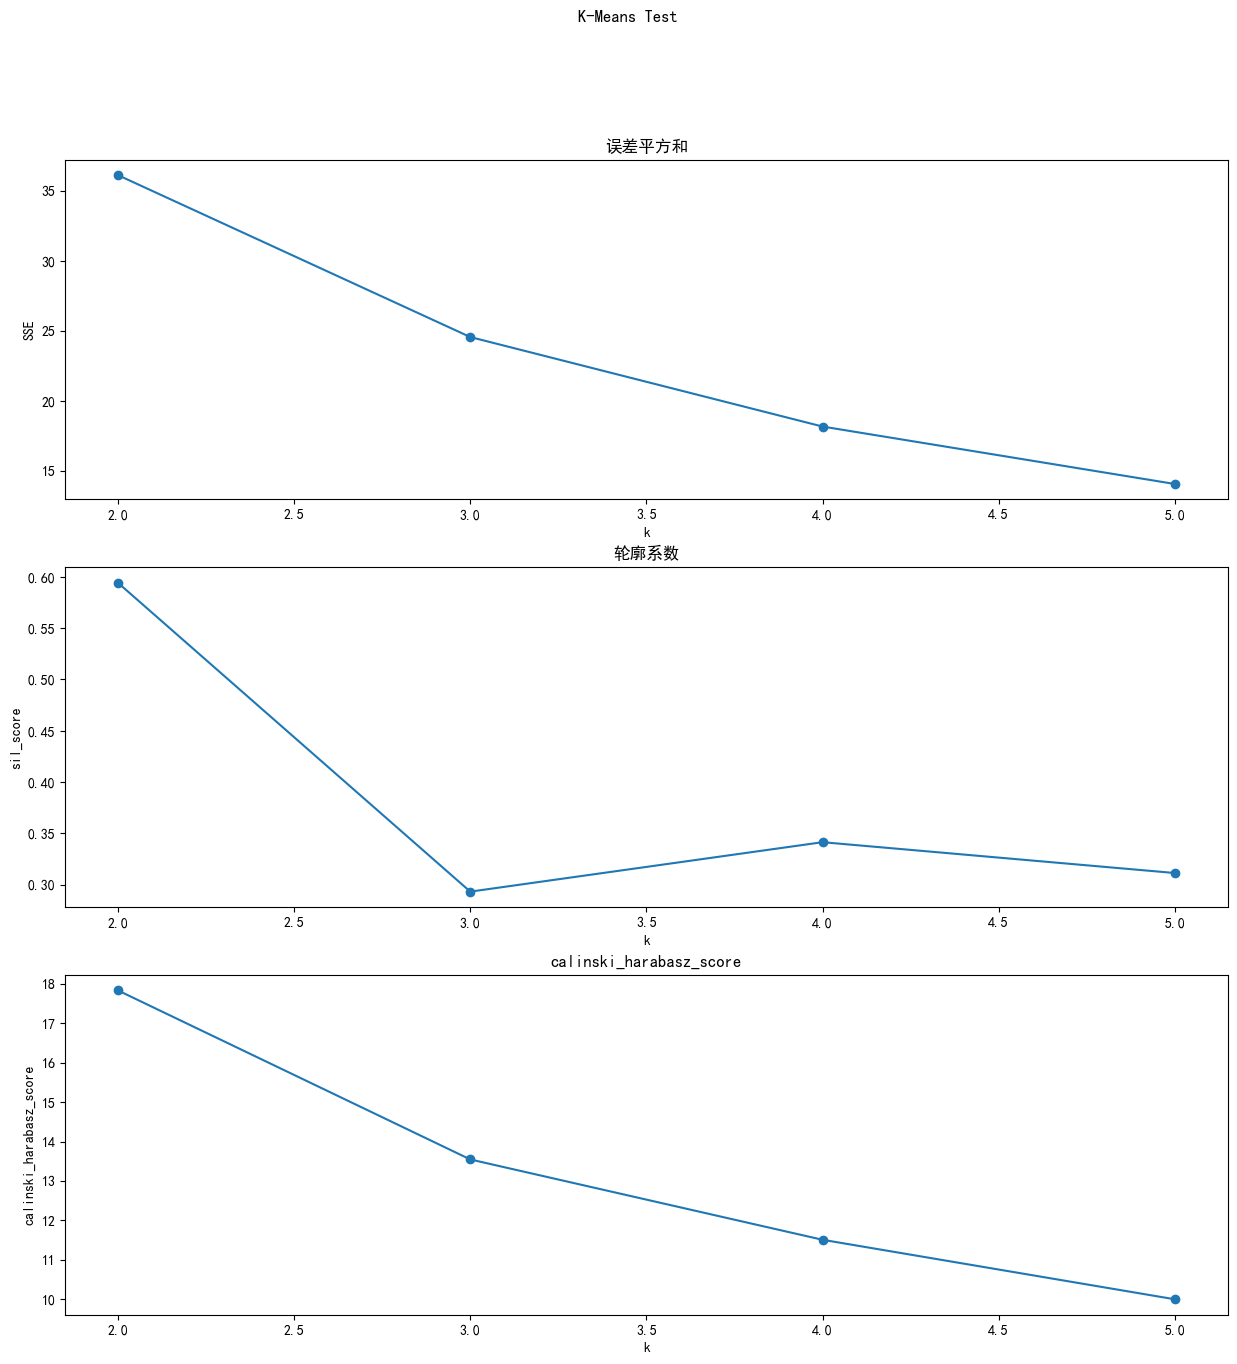

In [105]:
# 误差平方和
SSE = []  
# 轮廓系数
sil_score = []
# calinski_harabasz_score
calinski_harabasz_score = []

num = int(data.shape[0]/2)
for k in range(2,num + 1):
    model = KMeans(n_clusters=k).fit(data)  # 构造聚类器
    y_pred = model.predict(data)
    SSE.append(model.inertia_)                      # estimator.inertia_获取聚类准则的总和
    sil_score.append(silhouette_score(data,y_pred,metric='euclidean'))
    calinski_harabasz_score.append(metrics.calinski_harabasz_score(data,y_pred))          # 越大越好
X = range(2,num+1)

fig = plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.plot(X,SSE,'o-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title("误差平方和")

plt.subplot(3, 1, 2)
plt.plot(X,sil_score,'o-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title("轮廓系数")

plt.subplot(3, 1, 3)
plt.plot(X,calinski_harabasz_score,'o-')
plt.xlabel('k')
plt.ylabel('calinski_harabasz_score')
plt.title("calinski_harabasz_score")

plt.suptitle("K-Means Test")

plt.show()

##### 图谱聚类

In [122]:
from sklearn.cluster import SpectralClustering

for index, gamma in enumerate((0.01,0.1,1,10)):
    for index2, k in enumerate(range(2,num+1,1)):
        y_pred = SpectralClustering(n_clusters=k, gamma=gamma).fit_predict(data)
        print("gamma", gamma, "n_clusters", k,"score:", metrics.calinski_harabasz_score(data, y_pred))


gamma 0.01 n_clusters 2 score: 17.838589176219088
gamma 0.01 n_clusters 3 score: 12.78668940150157
gamma 0.01 n_clusters 4 score: 10.85027920076546
gamma 0.01 n_clusters 5 score: 8.85269492192498
gamma 0.1 n_clusters 2 score: 17.838589176219088
gamma 0.1 n_clusters 3 score: 13.47060254734046
gamma 0.1 n_clusters 4 score: 11.08796913744854
gamma 0.1 n_clusters 5 score: 9.574510653754635
gamma 1 n_clusters 2 score: 17.838589176219088
gamma 1 n_clusters 3 score: 13.47060254734046
gamma 1 n_clusters 4 score: 10.850279200765465
gamma 1 n_clusters 5 score: 5.1952605784071215
gamma 10 n_clusters 2 score: 17.838589176219088
gamma 10 n_clusters 3 score: 13.47060254734046
gamma 10 n_clusters 4 score: 6.683454436190512
gamma 10 n_clusters 5 score: 5.277002095921159


In [8]:
from sklearn.cluster import SpectralClustering

In [9]:
SpectralClustering?

Init signature:
SpectralClustering(
    n_clusters=8,
    *,
    eigen_solver=None,
    n_components=None,
    random_state=None,
    n_init=10,
    gamma=1.0,
    affinity='rbf',
    n_neighbors=10,
    eigen_tol='auto',
    assign_labels='kmeans',
    degree=3,
    coef0=1,
    kernel_params=None,
    n_jobs=None,
    verbose=False,
)
Docstring:     
Apply clustering to a projection of the normalized Laplacian.

In practice Spectral Clustering is very useful when the structure of
the individual clusters is highly non-convex, or more generally when
a measure of the center and spread of the cluster is not a suitable
description of the complete cluster, such as when clusters are
nested circles on the 2D plane.

If the affinity matrix is the adjacency matrix of a graph, this method
can be used to find normalized graph cuts [1]_, [2]_.

When calling ``fit``, an affinity matrix is constructed using either
a kernel function such the Gaussian (aka RBF) kernel with Euclidean
distance ``d(X, X

##### 高斯混合

100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


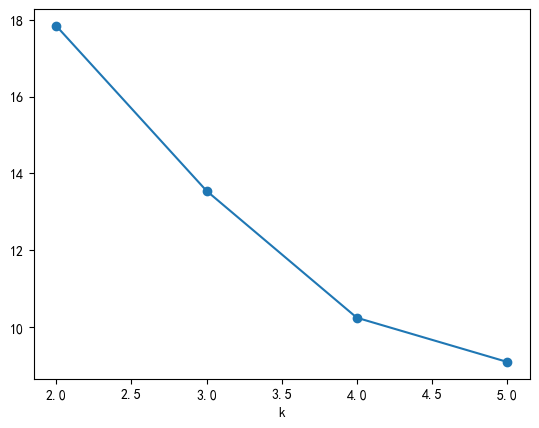

In [110]:
from sklearn.mixture import GaussianMixture

# calinski_harabasz_score
calinski_harabasz_score = []
for k in tqdm(range(2,num+1)):
    Gaussian = GaussianMixture(n_components=k,random_state=0).fit(data)
    y_pred = Gaussian.predict(data)
    calinski_harabasz_score.append(metrics.calinski_harabasz_score(data,y_pred))          # 越大越好

X = range(2,num+1)
plt.plot(X,calinski_harabasz_score,'o-')
plt.xlabel('k')
plt.show()

#### 层次聚类

In [179]:
ic_df

,liq_turn_avg,liq_zamount,corr_price_turn,mmt_normal_M,rat_mrq_ttm,ccr_mrq,dp_ttm,apr_mrq,ocf_yoy_mrq,liq_vstd,mmt_overmight_M,gpmd_ttm,ffoa_ttm,ep_mrq,np_parent_mrq,dpr,fatdy_mrq
datetime,,,,,,,,,,,,,,,,,
2016-02-01,0.110142,-0.074962,-0.140825,0.024220,0.139125,0.015291,0.020828,-0.067870,0.041405,0.028922,0.043152,0.001550,0.050177,-0.003500,0.003968,-0.006016,-0.034694
2016-02-02,0.132132,-0.061674,-0.115382,0.047776,0.111960,0.017800,0.019030,-0.062075,0.033429,0.054976,0.072889,-0.007416,0.037164,-0.008767,0.003287,-0.008017,-0.060458
2016-02-03,0.150432,-0.076120,-0.124160,0.046103,0.096671,0.039909,0.012028,-0.057321,0.037488,0.062623,0.092883,-0.012704,0.043936,-0.003202,0.006821,-0.019499,-0.066003
2016-02-04,0.188069,-0.084079,-0.111465,0.045859,0.106547,0.045888,0.028002,-0.047521,0.032617,0.067979,0.131588,-0.018000,0.046002,0.011484,0.021562,-0.012711,-0.068887
2016-02-05,0.146730,-0.052663,-0.106175,0.067167,0.098398,0.060873,0.035373,-0.023241,0.035074,0.055361,0.117311,-0.015717,0.051289,0.024349,0.031171,-0.012988,-0.082271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-25,-0.042746,-0.030910,-0.059386,-0.038491,0.007696,0.005145,0.048777,0.022615,0.023765,-0.088435,0.021883,0.108156,0.067833,0.102086,0.122272,0.025021,0.080329
2023-05-26,-0.065849,-0.038471,-0.058017,0.003814,0.025301,0.016200,0.039955,0.019934,0.020049,-0.100983,0.005117,0.111244,0.082785,0.100095,0.107262,0.021283,0.088001
2023-05-29,-0.026841,-0.027842,-0.021930,-0.000604,0.026943,-0.006236,0.034793,-0.006374,0.012055,-0.080883,0.012992,0.110744,0.053288,0.092330,0.094055,0.026958,0.099782


100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]


{0: ['liq_turn_avg', 'liq_vstd'], 1: ['ep_mrq', 'np_parent_mrq']}

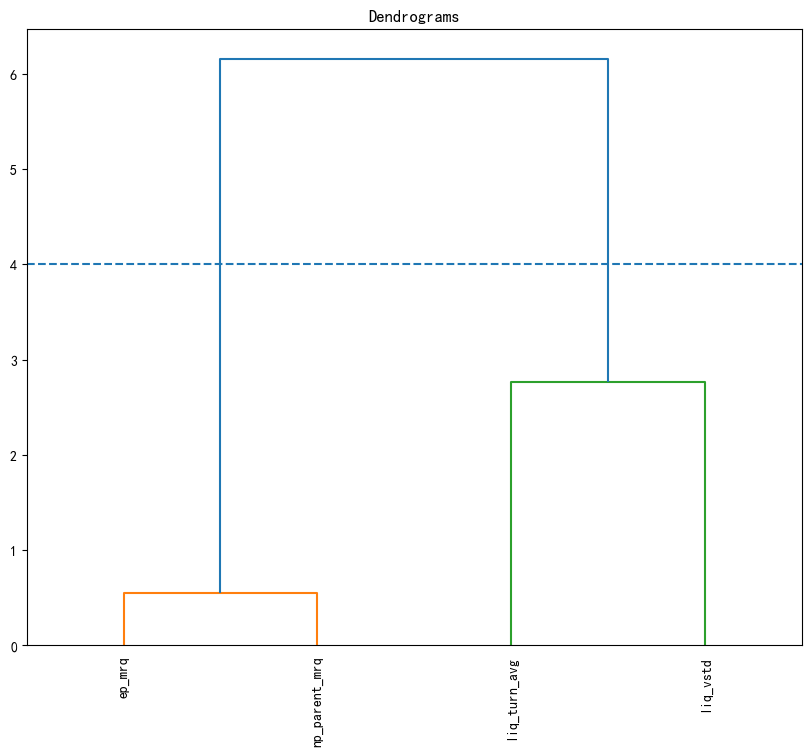

In [186]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

low,high = 0.7,1
corr_group = {}
## 高相关性分析
factor_corr = pd.DataFrame(ic_df[list(factor_dict.keys())].dropna().corr().stack())
factor_corr.columns = ['CORRELATION']
factor_corr.index.names = ['factor_a','factor_b']
factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()
data = ic_df[list(set(factor_corr.index.get_level_values(0)) | set(factor_corr.index.get_level_values(1)))].dropna().T

plt.figure(figsize=(10, 8))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(data, method='ward')
                      ,labels = data.index #orientation='left' #横向或者纵向呈现
                      ,leaf_rotation=90 #标签文字是否旋转
                      ,leaf_font_size=10 #标签文字大小
                      )
plt.hlines(y=4,xmin=0,xmax=1000,linestyles='--')

num = 2  # len(set(dend['leaves_color_list']))
cluster = AgglomerativeClustering(n_clusters=num, affinity='euclidean', linkage='ward')  
cat = pd.DataFrame(list(cluster.fit_predict(data)),index = data.index.tolist(),columns = ['group']).sort_values(by = 'group')

corr_group = {}
for i in tqdm(range(0,num)):
    corr_group[i] = cat[cat.group == i].index.tolist()

corr_group

100%|██████████| 2/2 [00:00<00:00, 999.71it/s]


{0: ['corr_price_turn',
  'liq_vstd',
  'liq_turn_avg',
  'liq_zamount',
  'mmt_normal_M'],
 1: ['ep_mrq',
  'mmt_overmight_M',
  'ffoa_ttm',
  'np_parent_mrq',
  'ocf_yoy_mrq',
  'fatdy_mrq',
  'dp_ttm',
  'gpmd_ttm',
  'apr_mrq',
  'rat_mrq_ttm',
  'ccr_mrq']}

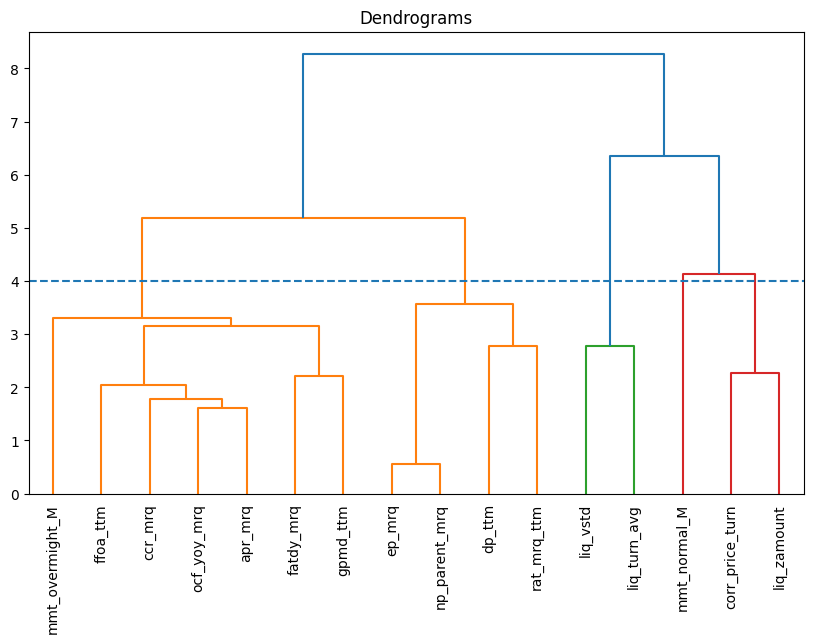

In [7]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc


low,high = 0.3,1
corr_group = {}
## 高相关性分析
factor_corr = pd.DataFrame(ic_df[list(factor_dict.keys())[:-1]].dropna().corr().stack())
factor_corr.columns = ['CORRELATION']
factor_corr.index.names = ['factor_a','factor_b']
factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()
data = ic_df[list(set(factor_corr.index.get_level_values(0)) | set(factor_corr.index.get_level_values(1)))].dropna().T

plt.figure(figsize=(10, 6))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(data, method='ward')
                      ,labels = data.index #orientation='left' #横向或者纵向呈现
                      ,leaf_rotation=90 #标签文字是否旋转
                      ,leaf_font_size=10 #标签文字大小
                      )
plt.hlines(y=4,xmin=0,xmax=1000,linestyles='--')

num = 2  # len(set(dend['leaves_color_list']))
cluster = AgglomerativeClustering(n_clusters=num, affinity='euclidean', linkage='ward')  
cat = pd.DataFrame(list(cluster.fit_predict(data)),index = data.index.tolist(),columns = ['group']).sort_values(by = 'group')

corr_group = {}
for i in tqdm(range(0,num)):
    corr_group[i] = cat[cat.group == i].index.tolist()

corr_group

#### 因子自动化合成处理

In [145]:
def orth_quick(orth_list,value_dict,value_dict_ = False):
        # 正交化函数
    def orth_function(orth):
        orth = orth.dropna()
        factor_names = orth.columns.tolist()
        orth.reset_index(inplace = True)
        # 数据运行
        factors_orthogonalization = pd.DataFrame()
        factors_orthogonalization_help = pd.DataFrame()                   #加速接力
        time_list = sorted(list(set(orth.datetime)))
        for i in time_list:
            factor_index = orth[orth.datetime == i].set_index(['datetime','order_book_id'])
            factor = factor_index[factor_names]
            M = (factor.shape[0]-1)* np.cov(factor.T.astype(float))   # 矩阵M
            D,U = np.linalg.eig(M)                                    # 获取特征值和特征向量
            U = np.mat(U)                                             # 转换为np中的矩阵
            d = np.mat(np.diag(D**(-0.5)))                            # 对特征根元素开(-0.5)指数
            S = U * d * U.T                                           # 获取过度矩阵S
            factors_orthogonal_mat = np.mat(factor) * S               # 获取对称正交矩阵
            factors_orthogonal= pd.DataFrame(factors_orthogonal_mat,columns = factor_names,index=factor.index)   # 矩阵转为dataframe
            if i < time_list[int(len(time_list)/2)]:
                factors_orthogonalization = pd.concat([factors_orthogonalization,factors_orthogonal],axis = 0)
            else:
                factors_orthogonalization_help = pd.concat([factors_orthogonalization_help,factors_orthogonal],axis = 0)
            print('\r 当前：{} / 总量：{}'.format(i,time_list[-1]),end='')
        factors_orthogonalization = pd.concat([factors_orthogonalization,factors_orthogonalization_help],axis = 0)
        factors_orthogonalization_help = 0

        return factors_orthogonalization
        
    df = pd.DataFrame()
    if value_dict_ == True:
        for k in orth_list:
            df = pd.concat([df,value_dict[k].stack()],axis = 1)
        df.columns = orth_list
    else:
        for k in orth_list:
            df = pd.concat([df,k.stack()],axis = 1)
        df.columns = [str(i) for i in list(range(0,len(orth_list)))] 

    df = df.sort_index()
    df.index.names = ['datetime','order_book_id']
    df = orth_function(df)
    df = df.sum(axis = 1).unstack('order_book_id')
    df = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)
    
    return df

In [158]:
pass_icir_factor = compare.index.to_list()

In [159]:
corr_group

{0: ['liq_turn_avg', 'liq_vstd'], 1: ['ep_mrq', 'np_parent_mrq']}

In [187]:
if len(corr_group[0]) != 0 :
    for i in list(corr_group.keys()):
        print(f'{corr_group[i]} 进入合成队列')
        del_list = []
        # 中高相关组内因子合成
        orth_df = orth_quick(corr_group[i],factor_dict,value_dict_ = True)
        orth_df = data_clean(orth_df)
        df,ic = Quick_Factor_Return_N_IC(orth_df,20,'orth')

        #对比原有因子 （如果复合因子强，则保留复合因子）
        corr_group_compare = pd.concat([compare.loc[list(set(corr_group[i])),'IR'],ic.set_index('name').IR],axis = 0).sort_values(ascending = False)
        if corr_group_compare.abs().sort_values(ascending=False).index[0] == 'orth':
            factor_dict[",".join(corr_group[i])] = orth_df
            ic_df[",".join(corr_group[i])] = df
            del_list = corr_group_compare.index[1:].tolist()
            for j in del_list:
                try:
                    pass_icir_factor.remove(j)
                except:
                    pass
            pass_icir_factor.append(",".join(corr_group[i]))
        else:
            del_list = corr_group_compare.index[1:].tolist()
            del_list.remove('orth')
            for j in del_list:
                try:
                    pass_icir_factor.remove(j)
                except:
                    pass

        # 高相关性下保留表现较好的因子的因子
        print('{}因子值中选择{}'.format(corr_group_compare.to_dict(),corr_group_compare.index[0]))

    # 因子过滤
    compare = ic_analysis(ic_df[pass_icir_factor])
else:
    print('无中相关项')
    pass

['liq_turn_avg', 'liq_vstd'] 进入合成队列
 当前：2023-06-30 00:00:00 / 总量：2023-06-30 00:00:00

100%|██████████| 1801/1801 [00:41<00:00, 43.49it/s]


{'name': 'orth', 'IC mean': 0.0892, 'IC std': 0.0995, 'IR': 0.8963, 'IR_ly': 1.0805, 'IC>0': 0.8186, 'ABS_IC>2%': 0.8933, 't_stat': 37.8237}
{'liq_turn_avg': 0.9105002173398671, 'orth': 0.8963, 'liq_vstd': 0.7647115966235859}因子值中选择liq_turn_avg
['ep_mrq', 'np_parent_mrq'] 进入合成队列
 当前：2023-06-30 00:00:00 / 总量：2023-06-30 00:00:00

100%|██████████| 1801/1801 [00:48<00:00, 37.34it/s]


{'name': 'orth', 'IC mean': 0.058, 'IC std': 0.0757, 'IR': 0.7651, 'IR_ly': 0.4145, 'IC>0': 0.7715, 'ABS_IC>2%': 0.8518, 't_stat': 32.2907}
{'orth': 0.7651, 'ep_mrq': 0.7566382014294853, 'np_parent_mrq': 0.7447733185976826}因子值中选择orth


In [189]:
factor_dict.keys()

dict_keys(['liq_turn_avg', 'liq_zamount', 'corr_price_turn', 'mmt_normal_M', 'rat_mrq_ttm', 'ccr_mrq', 'dp_ttm', 'apr_mrq', 'ocf_yoy_mrq', 'liq_vstd', 'mmt_overmight_M', 'gpmd_ttm', 'ffoa_ttm', 'ep_mrq', 'np_parent_mrq', 'dpr', 'fatdy_mrq', 'ep_mrq,np_parent_mrq'])

In [192]:
pass_icir_factor

['liq_turn_avg',
 'liq_zamount',
 'corr_price_turn',
 'mmt_normal_M',
 'rat_mrq_ttm',
 'ccr_mrq',
 'dp_ttm',
 'apr_mrq',
 'ocf_yoy_mrq',
 'mmt_overmight_M',
 'gpmd_ttm',
 'ffoa_ttm',
 'dpr',
 'fatdy_mrq',
 'ep_mrq,np_parent_mrq']

In [190]:
pickle.dump(factor_dict,open('factor_dict_final.pkl','wb'))

100%|██████████| 2/2 [00:00<00:00, 991.68it/s]


{0: ['gpmd_ttm', 'rat_mrq_ttm', 'fatdy_mrq', 'ep_mrq,np_parent_mrq'],
 1: ['liq_zamount', 'corr_price_turn']}

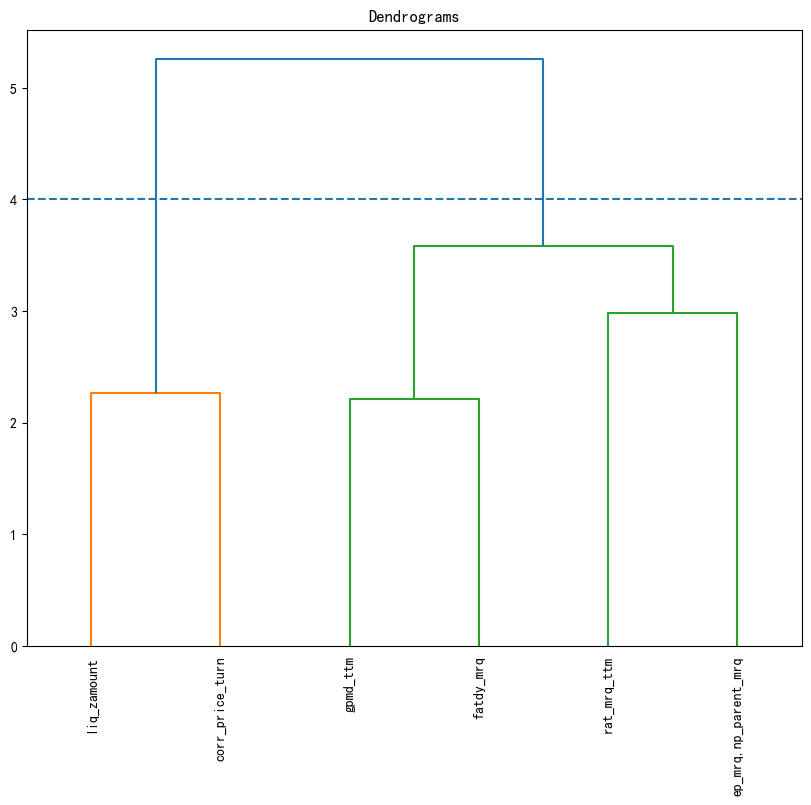

In [196]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

low,high = 0.6,1
corr_group = {}
## 高相关性分析
factor_corr = pd.DataFrame(ic_df[pass_icir_factor].dropna().corr().stack())
factor_corr.columns = ['CORRELATION']
factor_corr.index.names = ['factor_a','factor_b']
factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()
data = ic_df[list(set(factor_corr.index.get_level_values(0)) | set(factor_corr.index.get_level_values(1)))].dropna().T

plt.figure(figsize=(10, 8))  
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(data, method='ward')
                      ,labels = data.index #orientation='left' #横向或者纵向呈现
                      ,leaf_rotation=90 #标签文字是否旋转
                      ,leaf_font_size=10 #标签文字大小
                      )
plt.hlines(y=4,xmin=0,xmax=1000,linestyles='--')

num = 2  # len(set(dend['leaves_color_list']))
cluster = AgglomerativeClustering(n_clusters=num, affinity='euclidean', linkage='ward')  
cat = pd.DataFrame(list(cluster.fit_predict(data)),index = data.index.tolist(),columns = ['group']).sort_values(by = 'group')

corr_group = {}
for i in tqdm(range(0,num)):
    corr_group[i] = cat[cat.group == i].index.tolist()

corr_group

In [197]:
if len(corr_group[0]) != 0 :
    for i in list(corr_group.keys()):
        print(f'{corr_group[i]} 进入合成队列')
        del_list = []
        # 中高相关组内因子合成
        orth_df = orth_quick(corr_group[i],factor_dict,value_dict_ = True)
        orth_df = data_clean(orth_df)
        df,ic = Quick_Factor_Return_N_IC(orth_df,20,'orth')

        #对比原有因子 （如果复合因子强，则保留复合因子）
        corr_group_compare = pd.concat([compare.loc[list(set(corr_group[i])),'IR'],ic.set_index('name').IR],axis = 0).sort_values(ascending = False)
        if corr_group_compare.abs().sort_values(ascending=False).index[0] == 'orth':
            factor_dict[",".join(corr_group[i])] = orth_df
            ic_df[",".join(corr_group[i])] = df
            del_list = corr_group_compare.index[1:].tolist()
            for j in del_list:
                try:
                    pass_icir_factor.remove(j)
                except:
                    pass
            pass_icir_factor.append(",".join(corr_group[i]))
        else:
            del_list = corr_group_compare.index[1:].tolist()
            del_list.remove('orth')
            for j in del_list:
                try:
                    pass_icir_factor.remove(j)
                except:
                    pass

        # 高相关性下保留表现较好的因子的因子
        print('{}因子值中选择{}'.format(corr_group_compare.to_dict(),corr_group_compare.index[0]))

    # 因子过滤
    compare = ic_analysis(ic_df[pass_icir_factor])
else:
    print('无中相关项')
    pass

['gpmd_ttm', 'rat_mrq_ttm', 'fatdy_mrq', 'ep_mrq,np_parent_mrq'] 进入合成队列
 当前：2023-06-30 00:00:00 / 总量：2023-06-30 00:00:00

100%|██████████| 1801/1801 [00:47<00:00, 38.22it/s]


{'name': 'orth', 'IC mean': 0.0516, 'IC std': 0.076, 'IR': 0.6785, 'IR_ly': 0.344, 'IC>0': 0.7451, 'ABS_IC>2%': 0.8231, 't_stat': 28.633}
{'ep_mrq,np_parent_mrq': 0.7651474247803504, 'orth': 0.6785, 'gpmd_ttm': 0.57216464445669, 'rat_mrq_ttm': 0.4276968792766961, 'fatdy_mrq': 0.3699390803576792}因子值中选择ep_mrq,np_parent_mrq
['liq_zamount', 'corr_price_turn'] 进入合成队列
 当前：2023-06-30 00:00:00 / 总量：2023-06-30 00:00:00

100%|██████████| 1801/1801 [00:53<00:00, 33.47it/s]


{'name': 'orth', 'IC mean': 0.0708, 'IC std': 0.0654, 'IR': 1.0812, 'IR_ly': 0.7557, 'IC>0': 0.8529, 'ABS_IC>2%': 0.8501, 't_stat': 45.629}
{'orth': 1.0812, 'liq_zamount': 1.0178439938454578, 'corr_price_turn': 0.965117501985389}因子值中选择orth


In [198]:
pass_icir_factor

['liq_turn_avg',
 'mmt_normal_M',
 'ccr_mrq',
 'dp_ttm',
 'apr_mrq',
 'ocf_yoy_mrq',
 'mmt_overmight_M',
 'ffoa_ttm',
 'dpr',
 'ep_mrq,np_parent_mrq',
 'liq_zamount,corr_price_turn']

In [199]:
factor_dict.keys()

dict_keys(['liq_turn_avg', 'liq_zamount', 'corr_price_turn', 'mmt_normal_M', 'rat_mrq_ttm', 'ccr_mrq', 'dp_ttm', 'apr_mrq', 'ocf_yoy_mrq', 'liq_vstd', 'mmt_overmight_M', 'gpmd_ttm', 'ffoa_ttm', 'ep_mrq', 'np_parent_mrq', 'dpr', 'fatdy_mrq', 'ep_mrq,np_parent_mrq', 'liq_zamount,corr_price_turn'])

In [200]:
pickle.dump(factor_dict,open('factor_dict_final.pkl','wb'))

In [202]:
ic_df.to_pickle('ic_df_final.pkl')

In [203]:
ic_analysis(ic_df)

,IC,IR
liq_turn_avg,0.095730,0.910500
liq_zamount,0.058887,1.017844
corr_price_turn,0.064953,0.965118
mmt_normal_M,0.054143,0.540213
rat_mrq_ttm,0.029704,0.427697
ccr_mrq,0.019297,0.426976
dp_ttm,0.035603,0.596828
apr_mrq,0.007828,0.239547
ocf_yoy_mrq,0.006723,0.183438
liq_vstd,0.065896,0.764712
